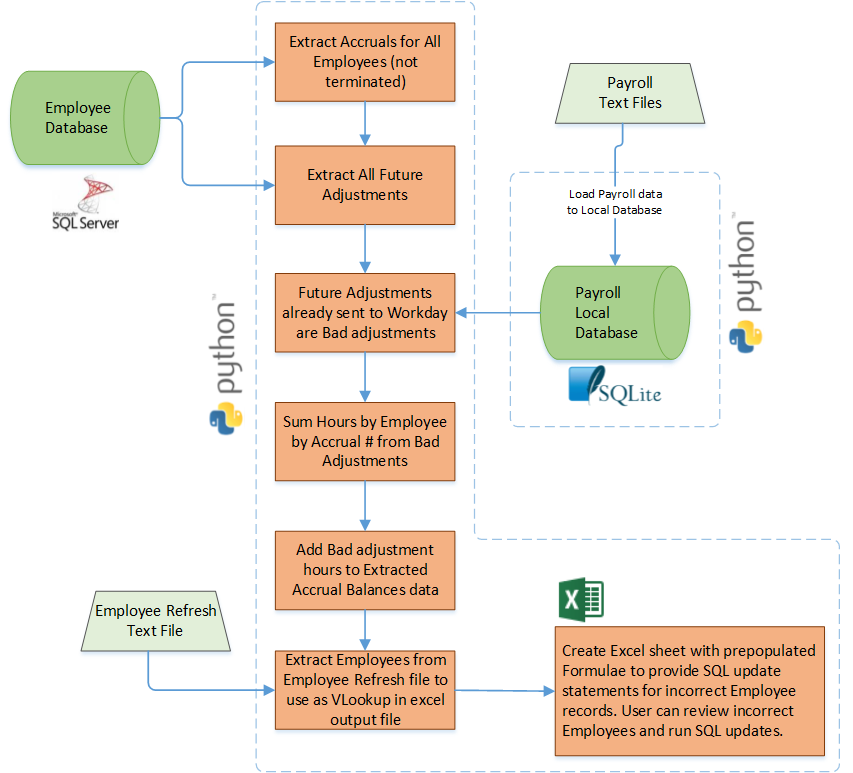

In [ ]:
############################################################################################################
# Script to get Accrual values and Future adjustments from Employee Database and load them in excel sheets.
# It also compares them with Payroll database and marks whether future adjustments were already sent or not
# If Future adjustment was already sent in Payroll, it indicates Payroll date and Payroll file for reference
# It then dumps the values into output Excel sheet.
############################################################################################################
# Author: Rajkumar Rajendran
############################################################################################################
# Things to check before executing this script
# - Ensure the PYODBC connection has the right server and password set (in 'server' and 'password' variables)
# - Ensure the PAYROLL.db file location (in 'conn' variable) is correct
# - Ensure the excel output filename (in 'writer' variable) is modified as needed.
############################################################################################################
import pandas as pd
import pyodbc
import sqlite3
import numpy as np


# function to execute insert_sql for pay_group and class passed as parameters and returns dataframe
def get_accrual_values(pg, cls):
    global accrual_recon_sql, cnxn
    params = [pg, cls]
    print('read insert_sql for {}'.format(pg))
    df = pd.read_sql_query(accrual_recon_sql, cnxn, params=params)
    df.insert(loc=0, column='PAYGROUP', value=pg)
    return df


# function to get Future adjustments and return a dataframe
def get_fut_adj():
    global future_adjust_sql, cnxn
    df = pd.read_sql_query(future_adjust_sql, cnxn)
    return df


# insert_sql server details below to which connection be made
server = '<server_name>'
database = '<database_name>'
user_id = '<user_id>'
password = '<password>'

# Flag to check for future adjusts or Not check and extract just faulty records
chk_fut_adj = 'N'

# opening a connection to insert_sql server with details of server, user_id and password from variables
cnxn = pyodbc.connect(
    'DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + database + ';UID=' + user_id + ';PWD=' + password)

# Connect to SQLite database with PAYROLL data
conn = sqlite3.connect(r'<location of PAYROLL.db>')
c = conn.cursor()

# create output excel file
writer = pd.ExcelWriter(r'<location of output excel file>')

# list of tuples with pay group and class. Iterate this list to execute SQL with each sent as parameters
pay_groups = [('<pay_group1>', '<Class1>'), ('<paygroup2>', '<Class2>')]

print('start processing')

# Get Future Adjustments
# read Future adjust SQL File and prepare
future_adjust_sql_file = r'<location of Future_dated_adjustments.txt SQL file>'
future_adjust_sql = (' '.join(open(future_adjust_sql_file, 'r').readlines()))
print('Get Fut Adjustments')
if chk_fut_adj == 'Y':
    fut_adj_df = get_fut_adj()
else:
    fut_adj_df = pd.DataFrame(columns=['PAYROLL','DATE','ADJUST_DATE','CODE','ADJ_MIN','ACCRUAL_NUM'])


# Get correct SQL file based on Future Adjustments exists or not & prepare SQL
if len(fut_adj_df) > 0:
    print('Future Adjustments Exists - Pulling all Employees')
    accrual_recon_sql_file = r'<location of Accrual_Recon_Script_All_Emp.txt SQL file>'
else:
    print('NO Future Adjustments Exists - Pulling Incorrect Employees')
    accrual_recon_sql_file = r'<location of Accrual_Recon_Script_Incorrect_Emp.txt SQL file>'
accrual_recon_sql = (' '.join(open(accrual_recon_sql_file, 'r').readlines()))

# iterate pay group list, and call function with pay group and class as parameters
accrual_recon_df = pd.DataFrame()
for pay_group, class_ in pay_groups:
    accrual_recon_df = accrual_recon_df.append(get_accrual_values(pay_group, class_), ignore_index=True)

# Loop thru future adjustments and check if they have been already sent in PAYROLL files
# if already sent in PAYROLL get details of PAYROLL files and Payroll end dates and mark the PAYROLL_SENT flag accordingly
print('update PAYROLL flag whether is already sent in PAYROLL or not')
# create PAYROLL_SENT & REMARKS columns to be updated later.
fut_adj_df['PAYROLL_SENT'] = ''
fut_adj_df['REMARKS'] = ''
for i, row in enumerate(fut_adj_df.itertuples()):
    payroll = str(getattr(row, 'PAYROLL')).zfill(8)  # pad leading spaces with zeroes
    pdate = getattr(row, 'DATE').date()  # convert to date format
    code = str(getattr(row, 'CODE')).ljust(3)  # right pad with spaces as that is how is stored in database
    hrs = int(round((getattr(row, 'ADJ_MIN') / 60) * 10000))
    if hrs < 0:
        (hrs_abs, sign) = (abs(hrs), '}')
    else:
        (hrs_abs, sign) = (hrs, '{')
    c.execute('SELECT PAYROLL_ENDDT,ADJ_IND,FILE FROM PAYROLL WHERE PAYROLL=? AND PDATE=? AND CODE=? AND HRS=? AND SIGN=?',
              [payroll, pdate, code, hrs_abs, sign])
    result_list = c.fetchall()
    if len(result_list) > 0:
        payroll_ind = 'Y'
        remark = ','.join(str(x) for x in result_list)
    else:
        payroll_ind = 'N'
        remark = ''
    fut_adj_df.set_value(i, 'PAYROLL_SENT', payroll_ind)
    fut_adj_df.set_value(i, 'REMARKS', remark)

# Extract only those future adjustments sent in PAYROLL into separate dataframe
print('extract only those adj that have been sent in PAYROLL')
fut_adj_payroll_df = fut_adj_df.iloc[np.where(fut_adj_df.PAYROLL_SENT.values == 'Y')]

# Group by Payroll and Accrual Num and sum the adjustment minutes (on those adjustments already sent in PAYROLL)
# If empty dataframe just create columns and do not group by as it doesn't work on empty dataframe
print('group by future adjustments')
if len(fut_adj_payroll_df) > 0:
    fut_adj_grpby_df = pd.DataFrame(
        fut_adj_payroll_df.groupby(['PAYROLL', 'ACCRUAL_NUM'])['ADJ_MIN'].agg('sum')).reset_index()
else:
    fut_adj_grpby_df = pd.DataFrame(columns=['PAYROLL', 'ACCRUAL_NUM', 'ADJ_MIN'])

# Left join accrual_recon_df and fut_adj_grpby_df to get future adjustment values by accrual num for each payroll
accrual_fut_adj_merge_df = pd.merge(accrual_recon_df, fut_adj_grpby_df, on=['PAYROLL', 'ACCRUAL_NUM'], how='left')
accrual_fut_adj_merge_df['ADJ_MIN_y'].fillna(0, inplace=True)

# Write dataframes to excel worksheets
print('write to excel')
accrual_fut_adj_merge_df.to_excel(writer, sheet_name='Accrual_Mismatch', index=False)
fut_adj_df.to_excel(writer, sheet_name='Future_Adjusts', index=False)
fut_adj_grpby_df.to_excel(writer, sheet_name='Fut_Adj_GrpBy', index=False)

# commit SQL transactions and close cursor, save excel
cnxn.commit()
cnxn.close()
writer.save()

In [ ]:
############################################################################################################
# Script to update Employee IDs and populate excel formula and update scripts to fix Accrual Balances.
# It also compares them with PAYROLL database and marks whether future adjustments were already sent or not
# If Future adjustment was already sent in PAYROLL, it indicates PAYROLL date and PAYROLL file for reference
# It then dumps the values into Excel sheet.
############################################################################################################
# Author: Rajkumar Rajendran
############################################################################################################
# Things to check before executing this script
# - Ensure the output excel file was created and is referenced in 'wb' variable.
# - Ensure the excel output filename (in 'wb.save') is modified to create a new copy of excel file.
############################################################################################################
from tkinter.filedialog import askopenfilename
import openpyxl as opx
from openpyxl.styles import Font

emp_refresh_file = askopenfilename()

if not emp_refresh_file:
    print('You Need to select a file to proceed further. Pls try again')
    exit()

wb = opx.load_workbook(r'<location of excel output file created in first script>')
wb.create_sheet(title='EMP-Refresh')
hr_refresh_sheet = wb.get_sheet_by_name('EMP-Refresh')
accrual_sheet = wb.get_sheet_by_name('Accrual_Mismatch')
bold = Font(bold=True)

with open(emp_refresh_file, 'r') as hr_ref_file:
    for row_num, line in enumerate(hr_ref_file):
        if line[0] == '~':
            payroll = line[1:9]
            hr_refresh_sheet['A' + str(row_num + 1)] = payroll

(accrual_sheet['J1'], accrual_sheet['K1']) = ('COMP_CURR_VALUE', 'CHECK')
(accrual_sheet['L1'], accrual_sheet['M1']) = ('HR', 'SCRIPT')
(accrual_sheet['J1'].font, accrual_sheet['K1'].font) = (bold, bold)
(accrual_sheet['L1'].font, accrual_sheet['M1'].font) = (bold, bold)
for row in range(2, accrual_sheet.max_row + 1):
    accrual_sheet['J' + str(row)] = '=D' + str(row) + '-(G' + str(row) + '+H' + str(row) + '-I' + str(row) + ')'
    accrual_sheet['K' + str(row)] = "=E" + str(row) + "=J" + str(row)
    accrual_sheet['L' + str(row)] = "=MATCH(B" + str(row) + ",'EMP-Refresh'!$A:$A,0)"
    accrual_sheet['M' + str(row)] = '=CONCATENATE("UPDATE ACCRUALS_EMPLOYEES SET CURRENT_VALUE=",IF(J' + str(
        row) + '<0,0,J' + str(row) + ''')," WHERE PAYROLL='",TEXT(B''' + str(
        row) + ''',"00000000"),"' AND ACCRUAL_NUM=",C''' + str(row) + ',";")'
accrual_sheet.freeze_panes = 'A2'

wb.save(r'<create a copy of excel sheet with new name')